In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from numpy import datetime64
from pandas import Timestamp
from datetime import datetime
from pvlib import location
from pytz import timezone

from lib.utils import get_irradiance, integrate
from lib.boat_model import Panel, Motor, Battery, Other, Boat
from lib.event_model import EventResult, Event
from lib.boat_data import BoatInputData, BoatOutputData
from lib.energy_controller_model import EnergyController
from lib.competition_model import Competition


In [2]:
# Create solar dataset


site = location.Location(
    latitude=-22.924247,
    longitude=-43.097405,
    tz="America/Sao_Paulo",
    altitude=0,
    name="Niterói",
)

description = {
    "time": {
        "start": "2022-03-16",
        "end": "2022-03-23",
        "freq": "1min",
    },
}

clearsky_data = site.get_clearsky(
    pd.date_range(
        start=description["time"]["start"],
        end=description["time"]["end"],
        freq=description["time"]["freq"],
        tz=site.tz,
    )
)

clearsky_data["poa"] = get_irradiance(
    site_location=site,
    tilt=0,
    surface_azimuth=0,
    weather_data=clearsky_data,
)

clearsky_data = clearsky_data[
    description["time"]["start"] : description["time"]["end"]
][
    :-1
]  # -1 to remove the last 30 minutes

clearsky_data["Solar Energy"] = integrate(clearsky_data, 3600)["poa"]

input_data = BoatInputData(
    time=np.array(
        [time.to_datetime64() for time in clearsky_data.index.to_numpy()],
        dtype=datetime64,
    ),  # type: ignore
    poa=clearsky_data["poa"].to_numpy(),
)


# Create the competition


tzinfo = timezone(site.tz)

competition = Competition(
    name="fake",
    events=[
        Event(
            name="race1",
            description="long race 1",
            start=Timestamp(datetime(2022, 3, 16, 9, 00, tzinfo=tzinfo)),
            end=Timestamp(datetime(2022, 3, 16, 15, 00, tzinfo=tzinfo)),
        ),
        Event(
            name="race2",
            description="short race 1",
            start=Timestamp(datetime(2022, 3, 16, 16, 00, tzinfo=tzinfo)),
            end=Timestamp(datetime(2022, 3, 16, 17, 00, tzinfo=tzinfo)),
        ),
    ],
)


# Create the boat


boat = Boat(
    panel=Panel(efficiency=0.16, mppt_maximum_power=(4 * 300), area=(4 * 1.6 * 1.0)),
    motor=Motor(maximum_power=5000),
    battery=Battery(
        efficiency=0.8,
        soc_0=1.0,
        minimum_soc=0.05,
        maximum_energy=1500,
        maximum_power=10000,
    ),
    circuits=Other(power=0),
)

# Create the energy controller


class ConstantPowerController(EnergyController):
    def __init__(self, constant: float):
        self.constant = constant

    def run(
        self,
        dt: float,
        input_data: BoatInputData,
        output_data: BoatOutputData,
        boat: Boat,
    ) -> float:
        return self.constant


# Run the simulation
competition_result = competition.run(
    input_data=input_data, boat=boat, energy_controller=ConstantPowerController(0.3)
)


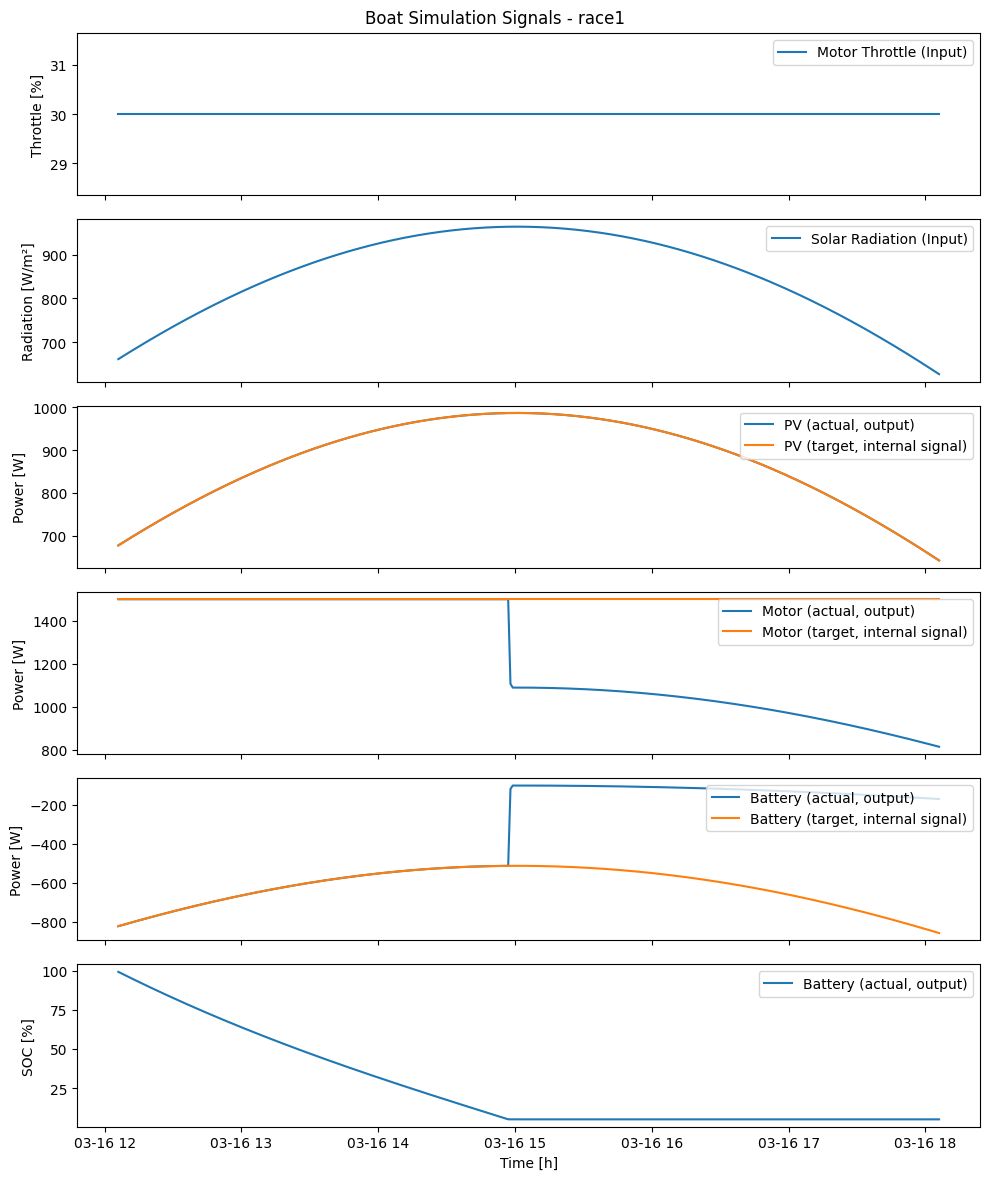

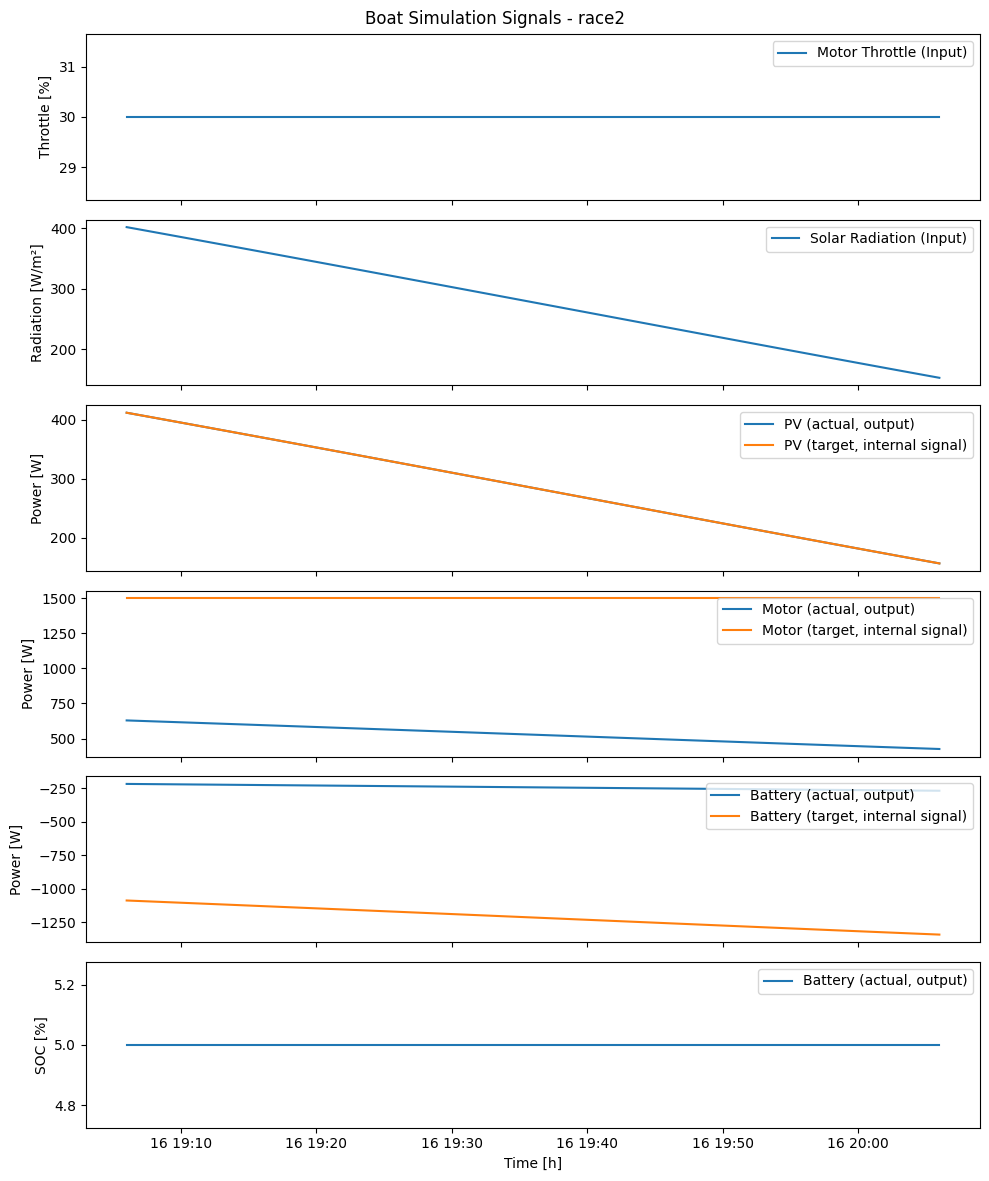

In [4]:
# Plot the simulation

for result in competition_result.results:

    fig, axs = plt.subplots(6, figsize=(10, 6 * 2.0), sharex=True, sharey=False)

    axs[0].plot(
        result.input_data.time,
        result.output_data.motor_target_throttle * 100,
        label="Motor Throttle (Input)",
    )
    axs[0].legend(loc="upper right")
    axs[0].set_ylabel("Throttle [%]")

    axs[1].plot(
        result.input_data.time,
        result.input_data.poa,
        label="Solar Radiation (Input)",
    )
    axs[1].legend(loc="upper right")
    axs[1].set_ylabel("Radiation [W/m²]")

    axs[2].plot(
        result.input_data.time,
        result.output_data.pv_output_power,
        label="PV (actual, output)",
    )
    axs[2].plot(
        result.input_data.time,
        result.output_data.pv_target_power,
        label="PV (target, internal signal)",
    )
    axs[2].legend(loc="upper right")
    axs[2].set_ylabel("Power [W]")

    axs[3].plot(
        result.input_data.time,
        result.output_data.motor_output_power,
        label="Motor (actual, output)",
    )
    axs[3].plot(
        result.input_data.time,
        result.output_data.motor_target_power,
        label="Motor (target, internal signal)",
    )
    axs[3].legend(loc="upper right")
    axs[3].set_ylabel("Power [W]")

    axs[4].plot(
        result.input_data.time,
        result.output_data.battery_output_power,
        label="Battery (actual, output)",
    )
    axs[4].plot(
        result.input_data.time,
        result.output_data.battery_target_power,
        label="Battery (target, internal signal)",
    )
    axs[4].legend(loc="upper right")
    axs[4].set_ylabel("Power [W]")

    axs[5].plot(
        result.input_data.time,
        result.output_data.battery_output_energy * 100,
        label="Battery (actual, output)",
    )
    axs[5].legend(loc="upper right")
    axs[5].set_ylabel("SOC [%]")

    plt.xlabel("Time [h]")
    plt.suptitle(f"Boat Simulation Signals - {result.name}")
    plt.tight_layout()
    plt.show()
